# An examination of the relative price in the Koopman model

In this project we want to examine the relative price set in the Koopman model. We want to see how the price depends on the parameters of the model. In doing so we take two approaches: First, we derive an analytical solution and plot the results in an interactive figure, second, we try to solve the by solving the model numerically. Specifically we use a bisection approach. The baseline model assumes that the consumer has a Cobb-Douglas utility function. We extend the model by assuming a CES-utility function. In this case we use brentq as a root finder from scipy. 

We want to stress out that we only focus on the price. This is in order to simplify the structure of the notebook and keep it more simple. Consumption or profit for instance could easily be calculated given the market clearing price. 

Imports and set magics:

In [1]:
import numpy as np
from scipy import optimize
import sympy as sm
import ipywidgets as widgets # Interactive plots
import matplotlib.pyplot as plt

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import analytical_solution as ana
import numerical_solution as num
import CES_function as ces

# 1. Model description of baseline model

**Time:** One period.

**Demographics:** One consumer and one firm. The firm is owned by the consumer and therefore the income also depends on the profit. We do not assume initial goods endowments. 

**Household:** For our baseline model we assume that the consumer has Cobb-Douglas preferences, where the two goods are the product (c) and leisure (l)
$$
\begin{aligned}
& \max \ u =c^{\alpha}*l^{1-\alpha}, 0<\alpha<1\\
 & \text{s.t.}\\
 & I=\Pi + w*L=p*c +w*l \\

\end{aligned}
$$

${\alpha}$ is the relative preference towards consumption, p is the price of the good, w is the wage, L is the initial labor endowment, l is leisure and $\Pi$ is the profit. We have assumed monotonicity and therefore the income is equal to the expenditures. Further, we have the firm problem: 
$$
\begin{aligned}
&\Pi =p*y-w*h

\end{aligned}
$$

The production function will be defined as follow, where the interpretation of A is TFP, and ${\beta}$ determines the returns to scale: 

$$
\begin{aligned}
&y =A*h^{\beta}, \beta <1 \\
&\max \ \Pi =p*A*h^{\beta}-w*h

\end{aligned}
$$

We assume the initial labor endowment is 24 hours, i.e. a day. We can therefore define the following relationship in equilibrium: 
$$
\begin{aligned}
&L=24=l+h

\end{aligned}
$$



**Equilibrium:** The equilibrium is defined where the labor market (l+h=24) and good market (y=c) clear. Further, the firm has maximized its profit and the consumer has maximized its utility. 



## 2. Analytical solution

The baseline model can be solved analytically. The starting point is to derive the firm's demand for labor. This is done by taking the FOC of the profit function w.r.t. working hours. This leads to the following result:  

$$
\begin{aligned}
& h^*=(\frac{\beta*p*A}{w})^{\frac{1}{1-\beta}}
\end{aligned}
$$

And from this the solutions for the firm's output and profit follow: 

$$
\begin{aligned}
& y^*=A*(\frac{\beta*p*A}{w})^{\frac{\beta}{1-\beta}}\\
& \Pi^*=p*A*(\frac{\beta*p*A}{w})^{\frac{\beta}{1-\beta}}-w(\frac{\beta*p*A}{w})^{\frac{1}{1-\beta}}
\end{aligned}
$$

Now, we can solve for the consumer's problem. It should be noted that the working hours and profit is exogenous for the consumer as the firm has already decided this based on the prices. As we have assumed a Cobb-Douglas function, we can use the standard solution shown below: 

$$
\begin{aligned}
& c^*=\alpha*\frac {I}{p}\\
& l^*=(1-\alpha)*\frac{I}{w}
\end{aligned}
$$

Where the income is: 

$$
\begin{aligned}
& I= \Pi+L = p*A*(\frac{\beta*p*A}{w})^{\frac{\beta}{1-\beta}}-w(\frac{\beta*p*A}{w})^{\frac{1}{1-\beta}} + L
\end{aligned}
$$



Now we can find the prices in equilibrium, that is, where the goods market and the labor market clear. We set the wage as numeraire, i.e. w=1, and then find the relative price p. We can then solve for the labor market: 

$$
\begin{aligned}
& l^*=L-h^*\\
& \leftrightarrow (1-\alpha)*(p*A*(\beta*p*A)^{\frac{\beta}{1-\beta}}-(\beta*p*A)^{\frac{1}{1-\beta}}+L)=L-(\beta*p*A)^{\frac{1}{1-\beta}}
\end{aligned}
$$

Solving this for p gives: 

$$
\begin{aligned}
& p^*=\frac {L^{1-\beta}}{A}*\frac {1}{(\beta^\frac {\beta}{1-\beta}*(1-\alpha)+\alpha*\beta^\frac {1}{1-\beta})^{1-\beta}}
\end{aligned}
$$

We see that higher productivity (A) decreases the price, which makes intuively sense as this will increase the supply. Further, higher demand ($\alpha$) will increase the price, which again makes intuitively sense. With this price we have the general solution, which can be plotted below. 

Note, given Walras' law, we know that this relative price also solves the goods market.

Now we have the general solution. This can be illustrated by using specific values for the parameters in the model. In the figure below we plot $\alpha$ on the x-axis and price on the y-axis, and then we add sliders for the values of $\beta$ and A.

In [2]:
#Interactive figure with beta and A as sliders. Beta cannot be 1 as this would result in a division by zero. 
widgets.interact(ana.interactive_figure,
    beta=widgets.FloatSlider(description=r"beta", min=0., max=0.99, step=0.10, value=0.5), 
    A=widgets.FloatSlider(description=r"A", min=1, max=10, step=1, value=5),
)

interactive(children=(FloatSlider(value=0.5, description='beta', max=0.99), FloatSlider(value=5.0, description…

<function analytical_solution.interactive_figure(beta, A)>

**Note**: We have been experiencing a bug, where the graphs are shown multiple times. The graphs are though identical. 

What we see from the graph directly follows from the points made above. Further, we see a decreasing relationship with $\beta$, when adjusting the slider for this parameter. This relationship also makes sense given that $\beta$ determines how much returns to scale are decreasing: A higher value of $\beta$ means higher returns to scale and from this follows a higher supply.

## 3. Numerical solution

In this section we solve the model numerically using the bisection approach. We use the bisection approach, because we know that when the goods market clears, then excess supply should be equal 0. We can use this to find the price that equilibriates supply and demand of the good: If excess supply is positive, then we know that the price is too high, and oppositely if excess supply is negative, then we know that the price is too low. 

**Problem:** Given a list of positive numbers, return the relative price that solves the goods market (and the labor market given Walras' Law).

**Inputs:** A range of possible solutions, and values of $\alpha$, $\beta$, A and L respectively.

**Outputs:** Relative price $p$.

**Algorithm:** `find_relative_price()`

1. For a given $p$, $\beta$, and $\alpha$ determine excess supply on the goods market and excess demand on the labor market following utility and profit maximization.
2. Set tolerance level $\epsilon$, maximum number of iterations, and lower and upper bounds for possible solutions: $p_{lower}$ and $p_{upper}$.
*  Note, the relative price cannot be negative.
3. Compute the excess supply for both the upper and lower bound: $ES(p_{lower})$ and $ES(p_{upper})$
4. Compute midpoint: $p_{mid}=\frac{p_{lower}+p_{upper}}{2}$
5. Compute excess supply for the midpoint: $ES(p_{mid})$
6. Update the interval:
  * If $ES(p_{lower})*ES(p_{mid})<0$ then update so $p_{upper}=p_{mid}$
  * If $ES(p_{mid})*ES(p_{upper})<0$ then update so $p_{lower}=p_{mid}$
7. Repeat step 3-6 until $ES(p_{mid})<\epsilon$

To again examine how the market clearing relative price changes for values of $\alpha$ and $\beta$ we now loop over ranges of values for these two parameters. Notice we have changed L (initial labor endowment) to 75 in order to stress out effects in section 4. 

In [3]:
#call class
sol=num.NumericalSolution()

In [4]:
#alpha. We set beta equal to ½. 

# a. determine size of vectors
N=10

# b. create empty vectors
alpha_vec_num=np.empty(N)
p_vec_num_alpha=np.empty(N)
c_clearing_alpha=np.empty(N)
l_clearing_alpha=np.empty(N)

# c. loop over the specified amount of alpha values and solve the model numerically each time
for i, alpha in enumerate(np.linspace(start=0.01, stop = 0.99, num=N)):
    # Call find_relative_price with current alpha value
    alpha_baseline=sol.par.alpha
    sol.par.alpha=alpha
    alpha_vec_num[i]=alpha
    p_vec_num_alpha[i],c_clearing_alpha[i], l_clearing_alpha[i] = sol.find_relative_price()
    sol.par.alpha=alpha_baseline

 Step 27.00: p = 0.06 -> Good clearing = -0.00004749. Labor clearing = -0.00. 
 Step 25.00: p = 0.22 -> Good clearing = -0.00002286. Labor clearing = -0.00. 
 Step 26.00: p = 0.31 -> Good clearing = -0.00003916. Labor clearing = -0.00. 
 Step 26.00: p = 0.39 -> Good clearing = 0.00009033. Labor clearing = 0.00. 
 Step 24.00: p = 0.46 -> Good clearing = -0.00002075. Labor clearing = -0.00. 
 Step 25.00: p = 0.54 -> Good clearing = -0.00009190. Labor clearing = -0.00. 
 Step 26.00: p = 0.61 -> Good clearing = 0.00004541. Labor clearing = 0.00. 
 Step 26.00: p = 0.69 -> Good clearing = -0.00003595. Labor clearing = -0.00. 
 Step 28.00: p = 0.77 -> Good clearing = 0.00002912. Labor clearing = 0.00. 
 Step 51.00: p = 0.86 -> Good clearing = 0.00004091. Labor clearing = 0.00. 


In [5]:
#beta. Here we set alpha equal to ½. 

beta_vec_num=np.empty(N)
p_vec_num_beta=np.empty(N)
c_clearing_beta=np.empty(N)
l_clearing_beta=np.empty(N)

for i, beta in enumerate(np.linspace(start=0.01, stop = 0.8, num=N)):
    # Call find_relative_price with current beta value
    beta_baseline=sol.par.beta
    sol.par.beta=beta
    beta_vec_num[i]=beta
    p_vec_num_beta[i],c_clearing_beta[i], l_clearing_beta[i] = sol.find_relative_price()
    sol.par.beta=beta_baseline

 Step 19.00: p = 3.72 -> Good clearing = -0.00008230. Labor clearing = -0.00. 
 Step 17.00: p = 2.84 -> Good clearing = 0.00005108. Labor clearing = 0.00. 
 Step 22.00: p = 2.00 -> Good clearing = 0.00001349. Labor clearing = 0.00. 
 Step 22.00: p = 1.38 -> Good clearing = -0.00009603. Labor clearing = -0.00. 
 Step 23.00: p = 0.94 -> Good clearing = -0.00003160. Labor clearing = -0.00. 
 Step 23.00: p = 0.63 -> Good clearing = -0.00005211. Labor clearing = -0.00. 
 Step 22.00: p = 0.42 -> Good clearing = 0.00004796. Labor clearing = 0.00. 
 Step 27.00: p = 0.28 -> Good clearing = -0.00008539. Labor clearing = -0.00. 
 Step 30.00: p = 0.19 -> Good clearing = -0.00004326. Labor clearing = -0.00. 
 Step 35.00: p = 0.13 -> Good clearing = -0.00008407. Labor clearing = -0.00. 


And present them in two separate figures:

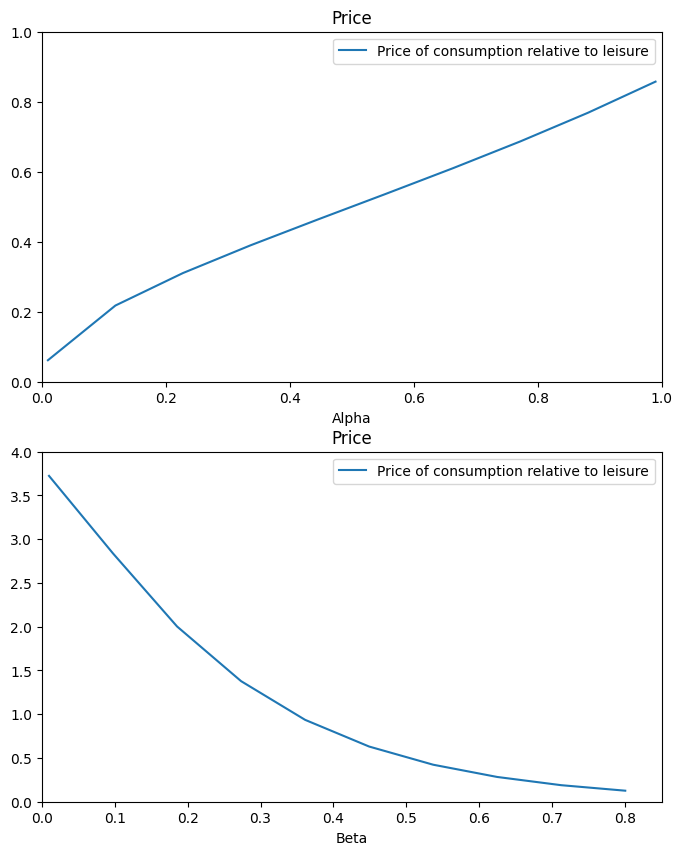

In [6]:
# a. figure with alpha on x-axis
fig = plt.figure(figsize=(8,10))
dx = fig.add_subplot(2,1,1)
dx.plot(alpha_vec_num, p_vec_num_alpha, label='Price of consumption relative to leisure')
dx.set_xlim([0.0,1]) # 
dx.set_ylim([0,1]) #
dx.set_title("Price")
dx.set_xlabel("Alpha") 
dx.legend(loc= 'upper right')

# b. figure with beta on x-axis
dx = fig.add_subplot(2,1,2)
dx.plot(beta_vec_num, p_vec_num_beta, label='Price of consumption relative to leisure')
dx.set_xlim([0.0,0.85]) # 
dx.set_ylim([0,4]) #
dx.set_title("Price")
dx.set_xlabel("Beta") 
dx.legend(loc= 'upper right')

plt.show()

From the graphs we see the same relationship as in section 2. See that section for interpretation.

# 4. Further analysis

In this section we will change the utility function for the consumer. The reason for this is that with a Cobb-Douglas function we make som strong assumptions about the degree of substitutability. To be specific, we assume that the income effect is equal to the substitution effect with Cobb-Douglas. However, it could easily be stated that the leisure and consumption is closer to be perfect complements (low value of $\sigma$), because you cannot enjoy leisure without consumption, and consumption without time to consume is also not that valuable. We will also see how an assumption about leisure and consumption is more like perfect substitutes (high value of $\sigma$) will affect the price change for a change in $\beta$. Our new utility function is: 

$$
\begin{aligned}
& u =(c^{\frac {\sigma-1}{\sigma}}+l^{\frac {\sigma-1}{\sigma}})^{\frac {\sigma}{\sigma-1}}, 0<\sigma<\infty \\
 & \text{s.t.}\\
 & I=\Pi + w*L=p*c +w*l \\
\end{aligned}
$$

It should (again) be noted we set the initial labor endowment equal to 75 in order to strength the tendency in the optimization problem. It is only  to stress out the effect of changes in $\beta$

In [7]:
#call ces-class
ces=ces.NumericalSolutionCES()

**Problem:** Given a list of positive numbers, return the relative price that solves the goods market (and the labor market given Walras' Law).

**Inputs:** A range of possible solutions, and values of $\alpha$, $\beta$, A and L respectively.

**Outputs:** Relative price $p$.

**Algorithm:** `find_relative_price()`

1. For a given $p$, $\beta$, and $\sigma$ determine excess supply on the goods market and excess demand on the labor market following utility and profit maximization.
2. Set lower and upper bounds for possible solutions: $p_{lower}$ and $p_{upper}$.
*  Note, the relative price cannot be negative.
3. Use the brentq method in scipy optimize to find the market clearing price. 

Step 3 differs from section 3 (*step 3-7*) as we use brentq. This is in order to save time as our algorithm from section 3 is more time consuming. brentq is used instead of bisect in this example, as brentq turns out to be more efficient. 

 Beta = 0.20. Sigma = 0.10  p = 3.79 -> Good clearing = 0.00. Labor clearing = 0.00.
 Beta = 0.45. Sigma = 0.10  p = 0.48 -> Good clearing = -0.00. Labor clearing = -0.00.
 Beta = 0.70. Sigma = 0.10  p = 0.13 -> Good clearing = 0.00. Labor clearing = 0.00.
 Beta = 0.20. Sigma = 0.50  p = 2.54 -> Good clearing = 0.00. Labor clearing = 0.00.
 Beta = 0.45. Sigma = 0.50  p = 0.56 -> Good clearing = 0.00. Labor clearing = 0.00.
 Beta = 0.70. Sigma = 0.50  p = 0.17 -> Good clearing = 0.00. Labor clearing = 0.00.
 Beta = 0.20. Sigma = 5.00  p = 1.18 -> Good clearing = -0.00. Labor clearing = -0.00.
 Beta = 0.45. Sigma = 5.00  p = 0.82 -> Good clearing = -0.00. Labor clearing = -0.00.
 Beta = 0.70. Sigma = 5.00  p = 0.26 -> Good clearing = 0.00. Labor clearing = 0.00.
 Beta = 0.20. Sigma = 50.00  p = 1.02 -> Good clearing = -0.00. Labor clearing = -0.00.
 Beta = 0.45. Sigma = 50.00  p = 0.97 -> Good clearing = -0.00. Labor clearing = -0.00.
 Beta = 0.70. Sigma = 50.00  p = 0.44 -> Good clearin

(0.0, 5.0)

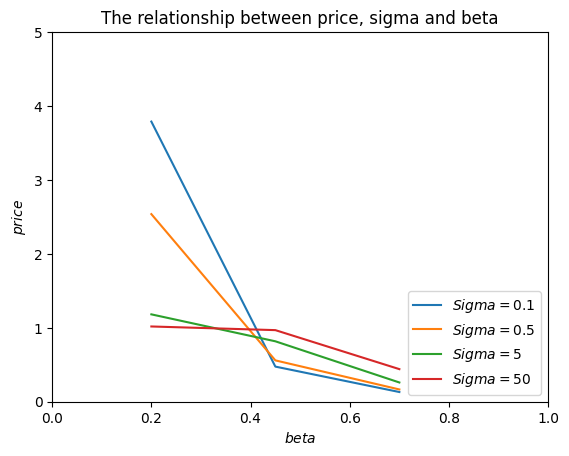

In [8]:

#a. Specify list of values of sigma to be considered
sigma_values=[0.10,0.5,5,50]

#b. Create empty vectors to be filled
beta_vec_ces = np.empty((3,))
sigma_vec_ces = np.empty((4,))
p_vec_beta_ces=np.empty((3,4))
c_clearing_beta_ces=np.empty((3,4))
l_clearing_beta_ces=np.empty((3,4))

#c. initiate plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

#d. solve model using for different values of beta and sigma + plot relationship
for j, sigma in enumerate(sigma_values):
    sigma_baseline=ces.par.sigma
    ces.par.sigma=sigma
    sigma_vec_ces[j] = sigma
    for i, beta in enumerate(np.linspace(start=0.2, stop = 0.7, num=3)):
        # Call find_relative_price with current alpha value
        beta_baseline=ces.par.beta
        ces.par.beta=beta
        beta_vec_ces[i]=beta
        p_vec_beta_ces[i,j], c_clearing_beta_ces[i,j], l_clearing_beta_ces[i,j] = ces.find_relative_price()
        ces.par.beta=beta_baseline
    ces.par.sigma=sigma_baseline
    ax.plot(beta_vec_ces,p_vec_beta_ces[:,j],label=f'$Sigma = {sigma}$')

#e. Specify layout of plot
ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_xlabel('$beta$')
ax.set_ylabel('$price$')
ax.set_title('The relationship between price, sigma and beta')
ax.set_xlim([0,1])
ax.set_ylim([0,5])


The results see from the figure above is in line with our expectations. Let's consider a decrease in $\beta$. This will give a lower supply in this model. Ceteris paribus this will give a higher price, but the elasticity of substitution will have an influence on the quantivately change. For $\sigma$ close to 0, we have almost perfect complements. Therefore, if the supply of goods decrease, the consumer will have to pay more for the good in order to keep a balance between leisure and consumption. This will lead to a large price increases, i.e. the blue curve. The opposite will be true for a high degree of substitutability, which is also what we can see from the red curve above.

# 5. Conclusion

In the baseline model we find a positive relationship between $\alpha$ and the price. This is because a higher $\alpha$ will increase the demand and hereby the price. On the other hand, we find a negative relationship between $\beta$ and the price, as a higher $\beta$ will increase supply and hereby the price. 

In our extended model we find that a higher degree of substitutability will lead to a lower effect on the price when $\beta$ (supply) is changing. This can be explained by the fact that if the supply goes down and consumption and leisure are close to be perfect complements, the consumer will need the consumption relatively more and therefore the price increase will be higher.